# Velocity gradient time series - Inkjet

Flow: transient nozzle flow with free surface (VoF). Simulation done with OpenFOAM interFoam solver, flow rate data from high speed imaging by Susannah Evans.

Steps of this script, for each Lagrangian trajectory:

1. Load velocity gradient data
2. De-noise using wavelet hard-thresholding
3. Normalize maximum strain rate (maximum eigenvalue of strain rate tensor), and multiply time by the inverse of this factor.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pywt

from ipywidgets import interactive
import ipywidgets as widgets

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

folder = 'inputs/inkjet'

files = [
    'Lagrangian0.csv',
]

output_file = 'inputs/inkjet/scenario_inkjet'

## Import velocity gradient data

In [11]:
times = []
gradUs = []
# Pre_normalizing factor (this is properly done later)
f = 0.5e6

for file in files:
    data = np.loadtxt(f'{folder}/{file}', delimiter=',', usecols=list(range(6,15))+[28], skiprows=1) 
    times.append(data[:,-1]*f)
    gradU = data[:,:-1].reshape((len(data), 3, 3))
    # Remove trace
    trgU = gradU[:,0,0] + gradU[:,1,1] + gradU[:,2,2]
    gradU = gradU - trgU[:, None, None]/3*np.full_like(gradU, np.eye(3))
    gradUs.append(gradU/f)

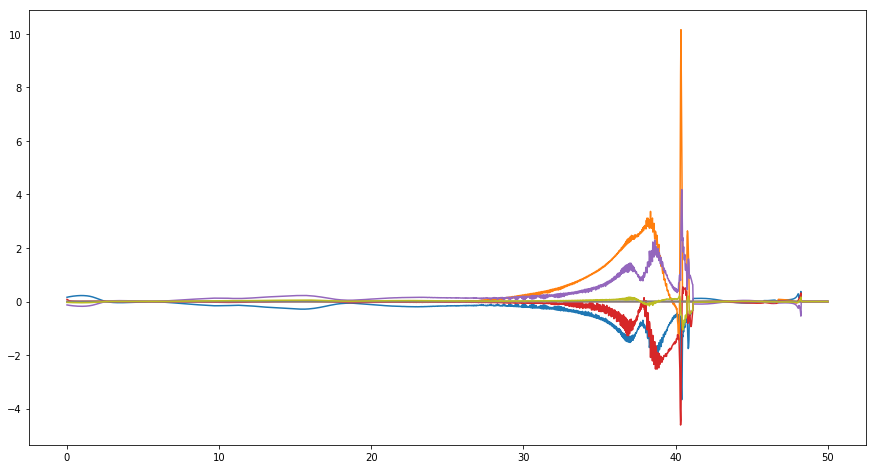

Max trace: 4.996003610813204e-16


In [12]:
plt.plot(times[0], gradUs[0].reshape(len(times[0]),9))
plt.show()
print(f"Max trace: {np.max(gradUs[0][:,0,0]+gradUs[0][:,1,1]+gradUs[0][:,2,2])}")

## Denoise with wavelet

In [23]:
gradUs_denoised = []
wavelet = 'coif3'

for gradU in gradUs:

    coeffs = pywt.wavedec(gradU, wavelet, mode='antireflect', axis=0)
    for i in range(1,len(coeffs)):
        coeffs[i][np.abs(coeffs[i])<0.5] = 0
    #coeffs[-1] = np.zeros_like(coeffs[-1])
    #coeffs[-2] = np.zeros_like(coeffs[-2]) 

    gradUs_denoised.append(pywt.waverec(coeffs, wavelet, mode='antireflect', axis=0))

In [24]:
def zoom(tb, trajectory, line):
    figure, ax = plt.subplots(nrows=2)
    ax[0].plot(gradUs[trajectory][:,line], label='original')
    ax[0].plot(gradUs_denoised[trajectory][:,line], label='smoothed', linewidth=2)
    ax[1].plot(gradUs[trajectory][tb[0]:tb[1],line], label='original')
    ax[1].plot(gradUs_denoised[trajectory][tb[0]:tb[1],line], label='smoothed', linewidth=2)
    ax[1].set_title('Zoom')
    ax[0].axvline(tb[0])
    ax[0].axvline(tb[1])
    
    plt.show()


w = interactive(zoom, tb=widgets.IntRangeSlider(
                    value=[0, len(gradUs[0])-1],
                    description='Index range:',
                    min=0,
                    max=len(gradUs[0])-1, 
                    continuous_update=False
                    ),
                     trajectory=widgets.Dropdown(
                    options=list(range(len(gradUs))),
                    value=0,
                    description='Trajectory #:',
                    disabled=False,
                    ),
                    line=widgets.Dropdown(
                    options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                    value=0,
                    description='Line:',
                    disabled=False,
                    )
                
               )
w

interactive(children=(IntRangeSlider(value=(0, 1999), continuous_update=False, description='Index range:', max…

## Analyse and normalize strain rate

Uniaxial elongation: 55.6%
Average Wi: 0.034857252930763596


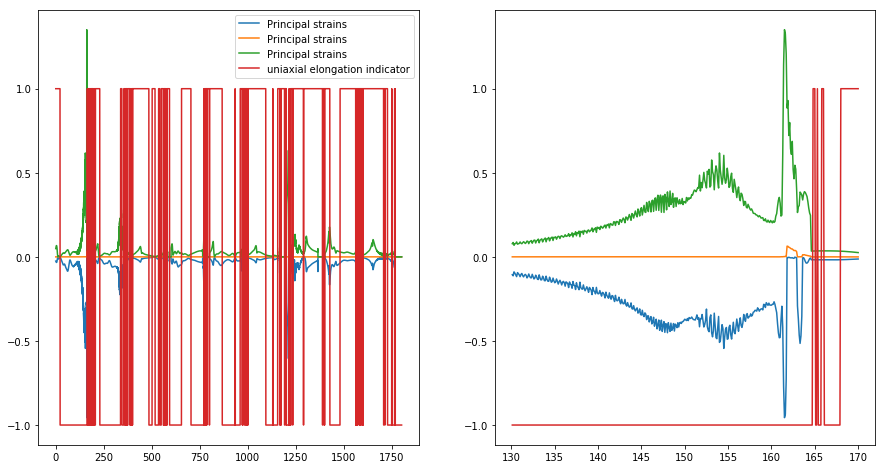

In [161]:
# Get principal values for the strain
D = 0.5*(gradU_denoised + np.transpose(gradU_denoised, axes=(0,2,1)))
strains = np.linalg.eigvalsh(D)

# Indicate whether strain is uni- of bi-axial
uniaxial = np.sign(strains[:,0]*strains[:,1]*strains[:,2])
print(f"Uniaxial elongation: {np.sum(uniaxial[uniaxial>0]/uniaxial.size*100):.3}%")
print(f"Average Wi:", np.sum(np.diff(time)*strains[:-1,2])/time[-1])

# Plot
fig, ax = plt.subplots(ncols=2)
ax[0].plot(time, strains, label='Principal strains')
ax[0].plot(time, uniaxial, label='uniaxial elongation indicator')
ax[0].legend()
ax[1].plot(time[1300:1700], strains[1300:1700], label='Principal strains')
ax[1].plot(time[1300:1700], uniaxial[1300:1700], label='uniaxial elongation indicator')
plt.show()

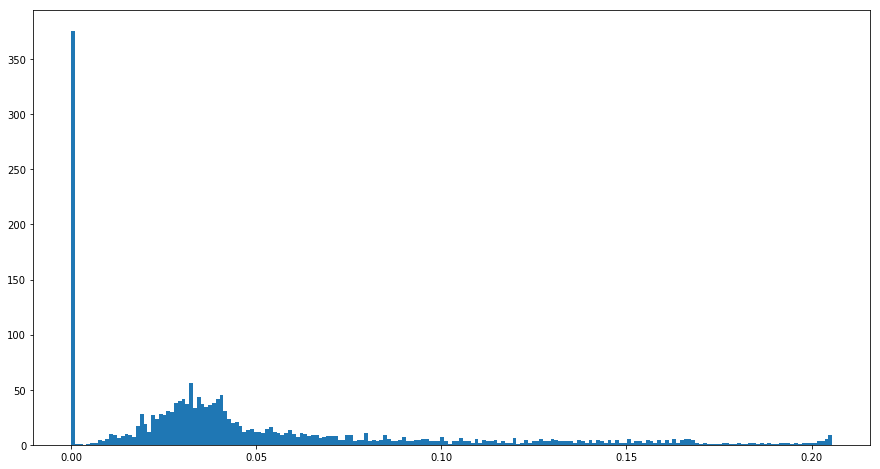

In [144]:
plt.hist(strains[:,2], bins=200)
plt.show()

In [112]:
np.savez_compressed(output_file, t=time, gradU=gradU_denoised)